# Set up

In [1]:
import pandas as pd
import datetime
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import math
import pymc as pm
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


We have to adjust registration dates before combining data because we infer correct year from what's represented in majority of data for that quarter.

HAVE to figure out what to do if class size doesn't match my own. Is there some way I can incorporate the students? Should I add them to the starting total -- make the difference all register 15 days before? Cut out the ones that are different? That sounds like a bad idea. Use a percentage of final enrolled multiplied by the actual class size to get the number enrolled at certain dates?

In [2]:
def upload_and_clean(file_paths: list):
  dfs = [pd.read_csv(path) for path in file_paths]
  cleaned = []

  for df in dfs:
    # standardize registration dates to month, day, year #
    parsed = pd.to_datetime(
        df['Registration Date'],
        errors='coerce',
        dayfirst=True
    )

    # find dominant year represented in dates
    modes = parsed.dt.year.dropna().mode()
      
    if len(modes) > 1:
        raise ValueError(f"Tie for dominant year: {modes.tolist()}")
    
    dominant_year = int(modes.iloc[0])
    
    # replace all years with dominant year
    df['Registration Date'] = parsed.apply(
        lambda d: d.replace(year=dominant_year) if pd.notna(d) else d
    )

    print(len(df))

    df = df.dropna(subset=['Registration Date']).copy()

    print(len(df)) # missing a lot for Q2 2024

    # combine student names
    df['Student Name'] = df['Student First Name'] + ' ' + df['Student Last Name']

    # reassign df
    cleaned.append(df)

  combined = pd.concat(cleaned, ignore_index=True)

  return combined

In [3]:
paths = [
    'C:/Users/sophi/Downloads/Enrollment data for Sophie G(Q2 2025).csv',
    'C:/Users/sophi/Downloads/Enrollment data for Sophie G(Q2 2024).csv',
    'C:/Users/sophi/Downloads/Enrollment data for Sophie G(Q3 2025).csv',
    'C:/Users/sophi/Downloads/Enrollment data for Sophie G(Q3 2024).csv'
]

In [4]:
### CHOOSE DATA SET ###

enroll = upload_and_clean(paths)

213
194
164
109
344
339
264
257


C:\Users\sophi\AppData\Local\Temp\ipykernel_13564\2102867488.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(
C:\Users\sophi\AppData\Local\Temp\ipykernel_13564\2102867488.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(
C:\Users\sophi\AppData\Local\Temp\ipykernel_13564\2102867488.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(
C:\Users\sophi\AppData\Local\Temp\ipykernel_13564\2102867488.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `

In [5]:
### INITIALIZE VARIABLES ###

MIN_SIZE = 3 # will not run class with fewer than 3 students
MAX_DAYS_BUCKET = 15

# Filtering

In [6]:
# We filter out classes without digits at the end because we need class dates.

def is_valid_class(df: pd.DataFrame) -> pd.Series:
  return (
    df['Product/Class'].str.contains('SAT PREP|ACT PREP|WORKSHOP|COURSE',case=False) &
    df['Product/Class'].str[-3:].str.isdigit()
  )

In [7]:
def extract_class_date(class_name: str, year: int):
  """
  Extract day and month from end of class name.
  Given year, month, day in form "730" or "1129", gives "7-30-2025".
  """
  day = class_name[-2:]
  month = class_name[-4:-2]
  monthday = date(int(year),int(month),int(day))
  return monthday

In [8]:
classes = enroll[is_valid_class(enroll)].copy()

In [9]:
# Registration year assumed to be class year
def date_difference(df: pd.DataFrame):
  df['Class Date'] = df.apply(
    lambda row: extract_class_date(row['Product/Class'], row['Registration Date'].year),
    axis = 1 # 1 is to apply to each row instead of each column
  )

  # Calculating time difference in days
  df['Class Date'] = pd.to_datetime(df['Class Date'])
  df['Registration Date'] = pd.to_datetime(df['Registration Date'])

  df['Days before class'] = (
    df['Class Date'] - df['Registration Date']
  ).map(lambda x: 0 if x.days < 0 else x.days) # removes negative days before values

  return df

In [10]:
classes = date_difference(classes)

We need to figure out the quarter each class takes place. We separate by when the class occurs rather than by when registration occurs.

In [11]:
def create_quarters(df: pd.DataFrame) -> pd.DataFrame:
    dates = df['Class Date']

    df['Quarter'] = np.select(
        [
            dates.dt.month < 4,
            (dates.dt.month >= 4) & (dates.dt.month < 7),
            (dates.dt.month >= 7) & (dates.dt.month < 10),
        ],
        ['Q1', 'Q2', 'Q3'],
        default='Q4'
    )

    return df

In [12]:
classes = create_quarters(classes)

In [13]:
print(classes.head())

   Order ID Registration Date Registration Time General Category  \
0   36993.0        2025-05-26           7:33 PM         SAT Prep   
1   37083.0        2025-06-02           1:03 PM   Essay Workshop   
2   36769.0        2025-05-06          11:42 PM         SAT Prep   
3   36995.0        2025-05-26           9:54 PM         SAT Prep   
4   36997.0        2025-05-26           9:57 PM         SAT Prep   

                              Product/Class  Order Subtotal  Order Total  \
0              SAT Prep at Annapolis HS 809           199.0        199.0   
1  College Essay Workshop at Crofton HS 812           199.0        199.0   
2              SAT Prep at Annapolis HS 510           219.0        219.0   
3              SAT Prep at Annapolis HS 809           199.0        199.0   
4              SAT Prep at Annapolis HS 809           199.0        199.0   

   Price Per Class  Number of Classes  Number of Total Classes  ...  \
0            199.0                1.0                      1.0 

# Creating days before class count

In [14]:
# Gives number of registrations X days before class.
def build_days_before(df: pd.DataFrame) -> dict:
    result = {}

    for class_id in range(1,len(df['Product/Class'].unique())+1):
        result[class_id] = (
            df[df['Product/Class'] == df['Product/Class'].unique()[class_id-1]]
            .groupby('Days before class')
            .agg(Students = ('Student Name', 'count'),Quarter = ('Quarter', 'first'))
            .reset_index()
        )

    return result

In [15]:
days_before_class = build_days_before(classes)

In [16]:
print(days_before_class[10])

   Days before class  Students Quarter
0                  1         1      Q2
1                  8         1      Q2
2                  9         1      Q2
3                 16         1      Q2


# Bucketing days

In [17]:
# We only consider the two weeks leading up to class date -- cap at 15 days.
def bucket_days(df: pd.DataFrame, days_bucket: int) -> pd.DataFrame:
  df = df.copy()

  df['Days before class'] = (
     df['Days before class']
     .clip(lower=0, upper=days_bucket)
  )

  return df

In [18]:
for class_name in days_before_class:
  days_before_class[class_name] = bucket_days(days_before_class[class_name],
                                                               MAX_DAYS_BUCKET)

In [19]:
print(days_before_class[10])

   Days before class  Students Quarter
0                  1         1      Q2
1                  8         1      Q2
2                  9         1      Q2
3                 15         1      Q2


# Cumulative student counts

In [20]:
# Creating cumulative count of students registered X days before class date.
def build_cumulative_counts(df: pd.DataFrame, index_range: range, index_col: str) -> pd.DataFrame:
    grouped = (
        df.groupby(index_col)
          .agg(Students=('Students', 'sum'))
          .reindex(index_range, fill_value=0)
          .sort_index(ascending=False)
    )

    grouped['Quarter'] = df['Quarter'].iloc[0]

    grouped['Students'] = grouped['Students'].cumsum()

    return grouped

In [21]:
cum_days_before = {
    c: build_cumulative_counts(days_before_class[c], range(0, MAX_DAYS_BUCKET + 1), 'Days before class')
    for c in days_before_class
}

In [22]:
print(cum_days_before[10])

                   Students Quarter
Days before class                  
15                        1      Q2
14                        1      Q2
13                        1      Q2
12                        1      Q2
11                        1      Q2
10                        1      Q2
9                         2      Q2
8                         3      Q2
7                         3      Q2
6                         3      Q2
5                         3      Q2
4                         3      Q2
3                         3      Q2
2                         3      Q2
1                         4      Q2
0                         4      Q2


# Combining classes into one df

In [23]:
# Transposing so that weeks/days before are columns and rows are unique classes
def combine_classes(dfs: dict, index_range: range) -> pd.DataFrame:
   result = {
      i: [dfs[class_name].at[i, 'Students'] for class_name in dfs]
      for i in index_range
   }

   return pd.DataFrame(result)

In [24]:
print(cum_days_before[10]['Quarter'].iloc[1])

Q2


In [25]:
summary = combine_classes(cum_days_before, range(0, MAX_DAYS_BUCKET+1))
summary['Success'] = [0 if summary[0].iloc[i] < 3 else 1 for i in range(len(summary))]
# success is 1, failure is 0
summary['Class ID'] = cum_days_before.keys()
summary['Quarter'] = [cum_days_before[i]['Quarter'].iloc[0] for i in range(1,len(cum_days_before)+1)]

In [26]:
print(summary.head())

    0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  Success  \
0  12  12  12  12  12  11  11  11  11  10  10   9   9   8   8   8        1   
1   6   6   6   5   5   5   5   5   5   5   5   5   5   5   5   4        1   
2   2   2   2   2   2   1   1   1   1   0   0   0   0   0   0   0        0   
3   9   9   8   8   8   8   8   8   7   6   6   6   5   5   5   5        1   
4   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1        0   

   Class ID Quarter  
0         1      Q3  
1         2      Q3  
2         3      Q2  
3         4      Q3  
4         5      Q3  


In [27]:
print(summary['Success'].value_counts())

Success
1    90
0    52
Name: count, dtype: int64


# Frequentist/percentile approach

In [28]:
### FREQUENTIST APPROACH FOR EACH CLASS/DAY COMBINATION ###

def find_percentile(data: pd.Series, level: int) -> int:
  """
  Percentile is rounded down; [1,2,3,4,5] will give 2 for 45%.
  """
  sorted = data.sort_values().reset_index(drop=True)
  size = len(sorted) + 1

  percentile = max(math.floor(level / 100 * size),1)

  return sorted[percentile-1]

In [29]:
def build_percentiles(df: pd.DataFrame, level: int) -> pd.DataFrame:
  percentiles = []
  for day in range(0,MAX_DAYS_BUCKET+1):
    percentiles.append(find_percentile(df[day],level))

  perc_df = pd.DataFrame(percentiles, columns=[f'{level}th percentile class'])
  perc_df.index.name = 'Days before class'

  return perc_df

In [30]:
percentile5th = build_percentiles(summary[summary['Quarter'] == 'Q3'],5)

In [31]:
print(build_percentiles(summary,25))
# graph of percent of classes that had at least three by certain day before

                   25th percentile class
Days before class                       
0                                      2
1                                      2
2                                      1
3                                      1
4                                      1
5                                      1
6                                      1
7                                      1
8                                      1
9                                      1
10                                     1
11                                     1
12                                     1
13                                     1
14                                     1
15                                     1


In [32]:
def percent_successful(df: pd.DataFrame, student_count: int) -> pd.DataFrame:
  percents = []

  for i in range(1,MAX_DAYS_BUCKET+1): # day 0 is final class count
    successes = len(df[(df[0] >= MIN_SIZE) & (df[i] == student_count)])
    total = len(df[df[i] == student_count])
    if total == 0:
      percent_success = 0
    else:
      percent_success = round(successes / total, 2)
    percents.append(percent_success)

  return percents

In [33]:
percent_success_zero_students = percent_successful(summary, student_count = 0)
percent_success_one_student = percent_successful(summary, student_count = 1)
percent_success_two_students = percent_successful(summary, student_count = 2)

In [34]:
print(percent_success_zero_students) # just not enough data -- 1/2 is 50% even though only two classes have 0 at that time
print(percent_success_one_student)
print(percent_success_two_students)
# how do i make sure this is meaningful without getting more data?
# not enough classes with size = 0
# use beta prior to inform p(s|x=0)

[0.0, 0.0, 0.1, 0.09, 0.09, 0.08, 0.07, 0.07, 0.07, 0.06, 0.06, 0.06, 0.06, 0.11, 0.11]
[0.04, 0.07, 0.04, 0.06, 0.06, 0.12, 0.14, 0.14, 0.24, 0.28, 0.31, 0.35, 0.39, 0.4, 0.4]
[0.17, 0.22, 0.26, 0.4, 0.5, 0.6, 0.67, 0.69, 0.67, 0.69, 0.68, 0.7, 0.67, 0.71, 0.77]


In [35]:
def build_percent_above_min(df: pd.DataFrame) -> pd.DataFrame:
  """
  Percent of classes that are at class min by i days before class.
  """
  num_classes = len(df)
  percents = []
  ones = [1] * num_classes

  for day in range(0,MAX_DAYS_BUCKET+1):
    p = len(df[df[day] > MIN_SIZE - 1][day]) / num_classes
    percents.append(p)

  early_cancel_risk = [ones[i]-percents[i] for i in range(len(percents))]

  perc_df = pd.DataFrame({'Percent above minimum' : percents,
                          'Risk of erroneous cancellation' : early_cancel_risk})
  perc_df.index.name = 'Days before class'

  return perc_df

In [36]:
print(build_percent_above_min(summary))

                   Percent above minimum  Risk of erroneous cancellation
Days before class                                                       
0                               0.633803                        0.366197
1                               0.598592                        0.401408
2                               0.584507                        0.415493
3                               0.577465                        0.422535
4                               0.556338                        0.443662
5                               0.535211                        0.464789
6                               0.492958                        0.507042
7                               0.464789                        0.535211
8                               0.450704                        0.549296
9                               0.436620                        0.563380
10                              0.422535                        0.577465
11                              0.415493           

# Binning days to improve data sparsity

In [37]:
bins = ['1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15+']

summary_binned = pd.DataFrame(
    {
        bins[i]: summary[[(2*i+1),(2*i+2)]].max(axis=1)
        for i in range(len(bins)-1)
    }
)
summary_binned['15+'] = summary[15]

In [38]:
students_binned = summary_binned.mask(summary_binned <= 1, '0-1').map(lambda x: str(x))
summary_binned_str = summary_binned.map(lambda x: str(x))

In [39]:
print(summary_binned.head())

   1-2  3-4  5-6  7-8  9-10  11-12  13-14  15+
0   12   12   11   11    10      9      8    8
1    6    5    5    5     5      5      5    4
2    2    2    1    1     0      0      0    0
3    9    8    8    8     6      6      5    5
4    1    1    1    1     1      1      1    1


In [40]:
print(students_binned.head())

   1-2  3-4  5-6  7-8 9-10 11-12 13-14  15+
0   12   12   11   11   10     9     8    8
1    6    5    5    5    5     5     5    4
2    2    2  0-1  0-1  0-1   0-1   0-1  0-1
3    9    8    8    8    6     6     5    5
4  0-1  0-1  0-1  0-1  0-1   0-1   0-1  0-1


In [41]:
for df in [summary_binned_str, students_binned, summary_binned]:
  df['Final count'] = summary[0]
  df['Success'] = summary['Success']
  df['Class ID'] = summary['Class ID']
  df['Quarter'] = summary['Quarter']

In [42]:
print(summary_binned.head())

   1-2  3-4  5-6  7-8  9-10  11-12  13-14  15+  Final count  Success  \
0   12   12   11   11    10      9      8    8           12        1   
1    6    5    5    5     5      5      5    4            6        1   
2    2    2    1    1     0      0      0    0            2        0   
3    9    8    8    8     6      6      5    5            9        1   
4    1    1    1    1     1      1      1    1            1        0   

   Class ID Quarter  
0         1      Q3  
1         2      Q3  
2         3      Q2  
3         4      Q3  
4         5      Q3  


In [79]:
print(summary_binned['Success'][summary_binned['Quarter'] == 'Q3'].value_counts())
print(summary_binned['Success'][summary_binned['Quarter'] == 'Q2'].value_counts())

Success
1    74
0    21
Name: count, dtype: int64
Success
0    11
1    10
Name: count, dtype: int64


In [43]:
print(students_binned.head())

   1-2  3-4  5-6  7-8 9-10 11-12 13-14  15+  Final count  Success  Class ID  \
0   12   12   11   11   10     9     8    8           12        1         1   
1    6    5    5    5    5     5     5    4            6        1         2   
2    2    2  0-1  0-1  0-1   0-1   0-1  0-1            2        0         3   
3    9    8    8    8    6     6     5    5            9        1         4   
4  0-1  0-1  0-1  0-1  0-1   0-1   0-1  0-1            1        0         5   

  Quarter  
0      Q3  
1      Q3  
2      Q2  
3      Q3  
4      Q3  


# Bayesian inference/Beta prior

In [44]:
# initializing prior constants (alpha/beta)
prior_strength = 2 # weak; eg., Beta(1,1) (uniform distribution) has prior strength 2
overall_success = summary['Success'].mean()
alpha = overall_success * prior_strength
beta = (1-overall_success) * prior_strength

In [45]:
def beta_success(df: pd.DataFrame, student_count: int) -> list:
  probabilities = []

  for i in range(0, len(bins)):
    successes = len(df[(df['Success'] == 1) & (df.iloc[:,i] == student_count)])
    failures = len(df[(df['Success'] == 0) & (df.iloc[:,i] == student_count)])
    post_alpha = alpha + successes
    post_beta = beta + failures

    # chance of success is ~Bin(n,p) where p~Beta(alpha+successes,beta+failures)
    # E[p] = (alpha + successes) / (alpha + beta + successes + failures)
    p_mean = round(post_alpha / (post_alpha + post_beta) * 100, 2)

    # ensure probabilities are monotonically decreasing
    if len(probabilities)>0 and p_mean < probabilities[-1]:
      probabilities.append(probabilities[-1])
    else:
      probabilities.append(p_mean)

  return probabilities

In [46]:
# probability of success for a class with X students N days before class
# where X is 0-1 or 2 and N is 1-2, 3-4, etc.
def build_prob_success(df: pd.DataFrame, student_counts: list):
  prob_success = pd.DataFrame({
      f'{student_count} students' : beta_success(df,student_count)
      for student_count in student_counts
  })

  add_zeros = pd.DataFrame([[0]*len(prob_success.columns)],columns=prob_success.columns)
  combined = pd.concat([add_zeros,prob_success],ignore_index=True)

  combined['Days before class'] = ['0'] + bins

  return combined

In [70]:
binned_prob_success = build_prob_success(students_binned[students_binned['Quarter'] == 'Q3'],['0-1','2'])
unbinned_prob_success = build_prob_success(summary_binned_str,['0','1','2'])

In [71]:
print(binned_prob_success)
# still issues with probabilities increasing as days decrease

   0-1 students  2 students Days before class
0          0.00        0.00                 0
1         16.20       28.45               1-2
2         21.78       36.87               3-4
3         21.78       62.60               5-6
4         22.90       77.46               7-8
5         31.80       77.46              9-10
6         34.32       78.49             11-12
7         42.80       78.49             13-14
8         46.48       82.23               15+


# Logistic model

Idea is that you model the probability with logistic regression so that it doesn't show increases in success when students decrease -- assuming the constant beta_1 is what we expect, logistic model forces monotone decreasing probabilities.

First, we have to convert to long format so that we can use day bins as a variable.

In [49]:
summary_long = summary_binned.melt(
    id_vars = ['Final count','Success','Class ID'],
    value_vars = bins,
    var_name = 'Days before',
    value_name = 'Students'
)

In [50]:
print(summary_long.head())

   Final count  Success  Class ID Days before  Students
0           12        1         1         1-2        12
1            6        1         2         1-2         6
2            2        0         3         1-2         2
3            9        1         4         1-2         9
4            1        0         5         1-2         1


In [51]:
"""
day_codes, day_idx = np.unique(summary_long['Days before'], return_inverse=True)

students = summary_long['Students'].values
success = summary_long['Success'].values

with pm.Model() as model:

  # hyperpriors
  beta_0 = pm.Normal('beta_0', mu=0, sigma=5)
  beta_1 = pm.Normal('beta_1', mu=0, sigma=2)

  sigma_u = pm.HalfNormal('sigma_u', sigma=1)

  # creating random variable for intercepts for day buckets
  u_raw = pm.Normal("u_raw", mu=0, sigma=1, shape=len(day_codes))
  u = pm.Deterministic("u", u_raw * sigma_u)

  # model
  logit_p = beta_0 + u[day_idx] + beta_1 * students

  # likelihood
  p = pm.math.sigmoid(logit_p)
  y = pm.Bernoulli('y', p=p, observed=success)

  trace = pm.sample(
      target_accept=0.95,
      draws=2000,
      tune=2000
      )
"""

'\nday_codes, day_idx = np.unique(summary_long[\'Days before\'], return_inverse=True)\n\nstudents = summary_long[\'Students\'].values\nsuccess = summary_long[\'Success\'].values\n\nwith pm.Model() as model:\n\n  # hyperpriors\n  beta_0 = pm.Normal(\'beta_0\', mu=0, sigma=5)\n  beta_1 = pm.Normal(\'beta_1\', mu=0, sigma=2)\n\n  sigma_u = pm.HalfNormal(\'sigma_u\', sigma=1)\n\n  # creating random variable for intercepts for day buckets\n  u_raw = pm.Normal("u_raw", mu=0, sigma=1, shape=len(day_codes))\n  u = pm.Deterministic("u", u_raw * sigma_u)\n\n  # model\n  logit_p = beta_0 + u[day_idx] + beta_1 * students\n\n  # likelihood\n  p = pm.math.sigmoid(logit_p)\n  y = pm.Bernoulli(\'y\', p=p, observed=success)\n\n  trace = pm.sample(\n      target_accept=0.95,\n      draws=2000,\n      tune=2000\n      )\n'

In [52]:
# very very bad result -- logistic model does not work

# Visualization

In [53]:
def plot_prob_success(df: pd.DataFrame):
  fig = go.Figure()

  for i in range(len(df.columns)-1):
    fig.add_trace(
      go.Scatter(
          x=df['Days before class'],
          y=df.iloc[:,i],
          mode='lines',
          name=df.columns[i]
      )
    )

  fig.update_layout(
      xaxis=dict(
          type='category',
          categoryorder='array',
          categoryarray=df['Days before class']
      ),
      yaxis=dict(
          title='Percent chance of success',
          range=[0, 100]
      ),
      xaxis_title='Days before class'
  )

  fig.show()

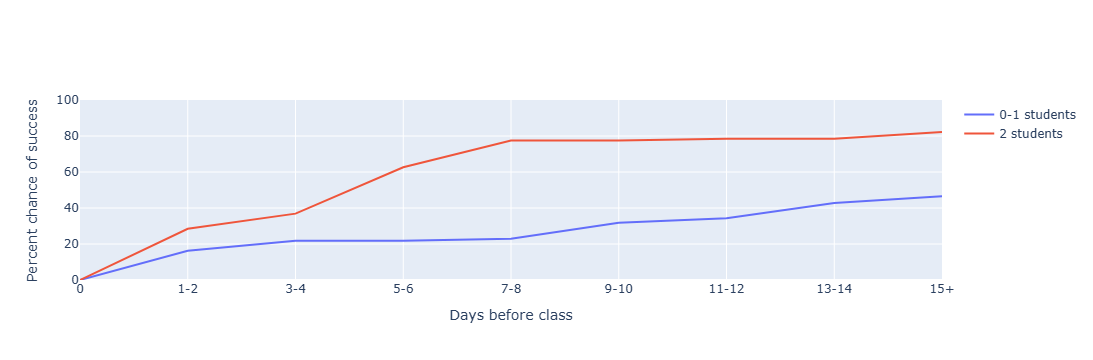

In [72]:
plot_prob_success(binned_prob_success)

In [73]:
def plot_for_slides(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(8, 4.5))

    x = df["Days before class"]

    for col in df.columns:
        if col == "Days before class":
            continue
        ax.plot(x, df[col], linewidth=2, label=col)

    # Labels and limits
    ax.set_xlabel("Days before class")
    ax.set_ylabel("Percent chance of success")
    ax.set_ylim(0, 100)

    # Remove default padding so 0 aligns with the origin
    ax.margins(x=0, y=0)

    # Ensure x is treated as categorical but starts at 0
    ax.set_xlim(-0.0, len(x) - 1)

    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x)

    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("success_probability.png", dpi=300, bbox_inches="tight")
    plt.close()

In [75]:
plot_for_slides(binned_prob_success) ### THIS IS FOR Q3!!!!!

# Exploratory data analysis/misc.

In [57]:
### EXPLORATORY DATA ANALYSIS ###

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_student_count(df: pd.DataFrame, x_max=20, y_max=10):
    count = df.groupby('Product/Class')['Student Name'].count()

    bins = np.arange(1, x_max + 2, 1)  # 1 to x_max inclusive

    plt.figure()
    plt.hist(count, bins=bins)

    plt.xlim(1, 15)
    plt.ylim(0, 30)
    plt.xticks(np.arange(1, 15 + 1, 1))
    plt.yticks(np.arange(0, 30 + 1, 1))

    plt.xlabel("Students per class")
    plt.ylabel("Number of classes")
    plt.title("Distribution of Student Counts")

    plt.tight_layout()
    plt.savefig('student_counts.png', dpi=300, bbox_inches="tight")

    plt.show()

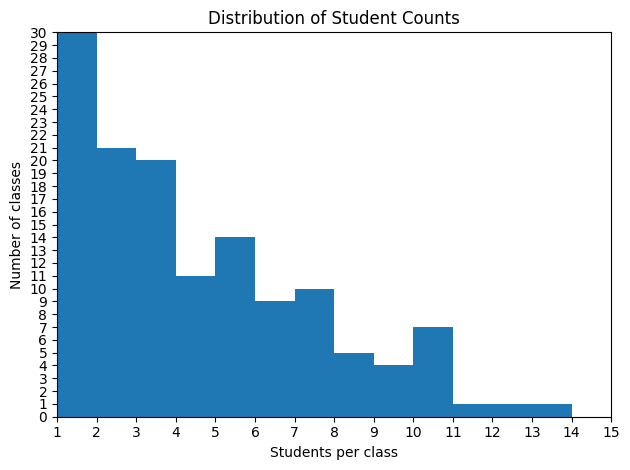

In [59]:
plot_student_count(classes)

In [60]:
stats_days = summary.describe().T

In [61]:
# How many classes of each type occurred in Q3?
# 1st row is # classes, 2nd row is # students taking a class of that type

def build_class_breakdown(df: pd.DataFrame) -> pd.DataFrame:
    class_count = [
        sum(df['Product/Class']
            .value_counts()
            .index
            .str.contains(i,case=False))
        for i in ['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE']
    ]

    student_count = [
        len(df[df['Product/Class']
                          .str.contains(i,case=False)])
        for i in ['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE']
    ]

    result = pd.DataFrame([class_count,student_count],
                                   columns=['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE'])

    return result

In [63]:
class_breakdown = build_class_breakdown(classes)

In [64]:
print(class_breakdown) # none of the ACT prep classes have at least 3 students

   SAT PREP  ACT PREP  WORKSHOP  COURSE
0        90        12        31       9
1       520        22       129      29


In [65]:
# When do most students sign up for a class? (aggregated as a sum across all classes)

def plot_enrollment_agg(df: pd.DataFrame):
    fig = px.histogram(df['Days before class'])

    fig.update_layout(
        xaxis = dict(title = 'Days until class'),
        yaxis = dict(title = 'Number of students'),
        title = 'Distribution of Student Enrollment Times'
    )

    fig.show()

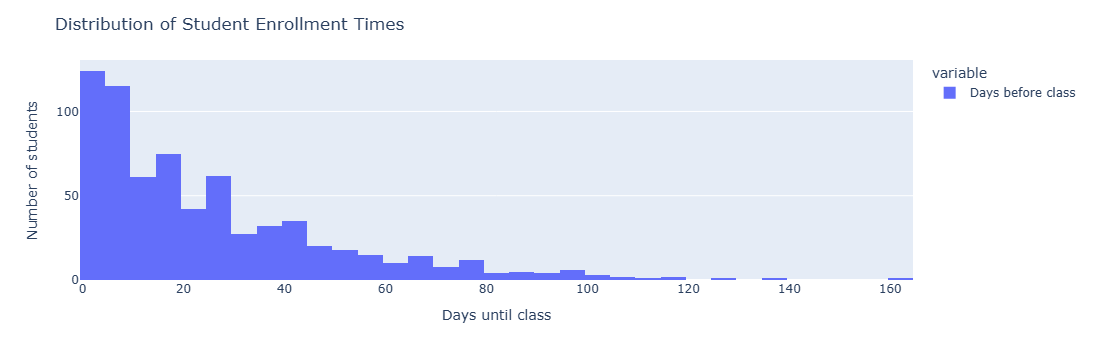

In [67]:
plot_enrollment_agg(classes)